In [ ]:
# Clone the GitHub repo
!git clone https://github.com/shujaullah/Housing-Price.git

# Move into the repo
%cd Housing-Price


fatal: destination path 'Housing-Price' already exists and is not an empty directory.
/content/Housing-Price


In [ ]:
!git config --global user.email "ingale.p@northeastern.edu"
!git config --global user.name "Parth Ingale"


In [ ]:
%cd /content/Housing-Price
!git checkout -b data-preprocessing-parth


/content/Housing-Price
Switched to a new branch 'data-preprocessing-parth'


In [ ]:
import os
os.listdir('/content/Housing-Price')


['.git', 'house-prices-advanced-regression-techniques']

In [ ]:
# Load the data from the subfolder
import pandas as pd
train = pd.read_csv("house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("house-prices-advanced-regression-techniques/test.csv")

# Quick checks
print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()


Train shape: (1460, 81)
Test shape: (1459, 80)


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [ ]:
# Summary of missing values in train data
missing = train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

# Display the missing values
missing.to_frame(name='Missing Count')


Missing Count
PoolQC                 1453
MiscFeature            1406
Alley                  1369
Fence                  1179
MasVnrType              872
FireplaceQu             690
LotFrontage             259
GarageType               81
GarageYrBlt              81
GarageFinish             81
GarageQual               81
GarageCond               81
BsmtExposure             38
BsmtFinType2             38
BsmtQual                 37
BsmtCond                 37
BsmtFinType1             37
MasVnrArea                8
Electrical                1

Text(0.5, 0, 'SalePrice')

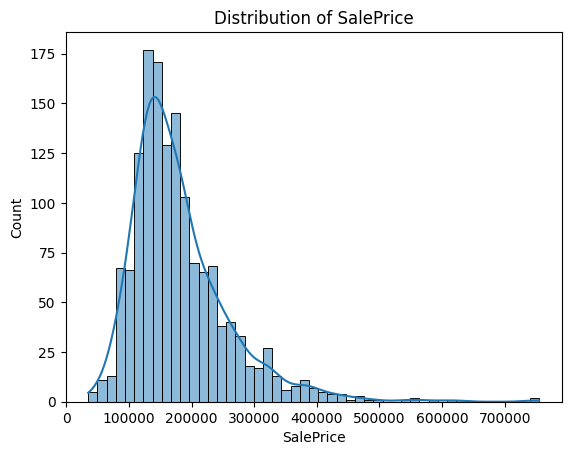

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(train['SalePrice'], kde=True)
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")


In [ ]:
# Get top 10 features most correlated with SalePrice
# Convert numeric features to numbers before calculating correlation
numeric_train = train.select_dtypes(include=['number'])  # Select only numeric columns

top_corr = numeric_train.corr()['SalePrice'].sort_values(ascending=False).head(11).index

# Plot heatmap
sns.heatmap(numeric_train[top_corr].corr(), annot=True, cmap='coolwarm')
plt.title("Top Correlated Features with SalePrice")
plt.show()

In [ ]:
# Separate numerical and categorical columns
numerical_cols = train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = train.select_dtypes(include=['object']).columns

# Check missing values in each type
num_missing = train[numerical_cols].isnull().sum()
cat_missing = train[categorical_cols].isnull().sum()

print("🔢 Numerical features with missing values:")
print(num_missing[num_missing > 0])

print("\n🔤 Categorical features with missing values:")
print(cat_missing[cat_missing > 0])


🔢 Numerical features with missing values:
LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

🔤 Categorical features with missing values:
Alley           1369
MasVnrType       872
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


In [ ]:
# Impute numerical columns with median
for col in num_missing[num_missing > 0].index:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(test[col].median())


In [ ]:
# Impute categorical columns with mode or 'Missing'
for col in cat_missing[cat_missing > 0].index:
    if train[col].mode().empty:
        # fallback if no mode
        fill_val = 'Missing'
    else:
        fill_val = train[col].mode()[0]

    train[col] = train[col].fillna(fill_val)
    test[col] = test[col].fillna(fill_val)


In [ ]:
print("✅ Missing values left in train:", train.isnull().sum().sum())
print("✅ Missing values left in test:", test.isnull().sum().sum())


✅ Missing values left in train: 0
✅ Missing values left in test: 22


In [ ]:
# Find columns with missing values in test set
missing_test = test.isnull().sum()
missing_test = missing_test[missing_test > 0].sort_values(ascending=False)
missing_test.to_frame(name="Missing Count")


Missing Count
MSZoning                  4
Utilities                 2
BsmtFullBath              2
BsmtHalfBath              2
Functional                2
Exterior2nd               1
Exterior1st               1
BsmtUnfSF                 1
BsmtFinSF2                1
BsmtFinSF1                1
TotalBsmtSF               1
KitchenQual               1
GarageCars                1
GarageArea                1
SaleType                  1

In [ ]:
# Handle remaining missing values in test set
for col in missing_test.index:
    if test[col].dtype in ['int64', 'float64']:
        test[col] = test[col].fillna(test[col].median())
    else:
        fill_val = test[col].mode()[0] if not test[col].mode().empty else 'Missing'
        test[col] = test[col].fillna(fill_val)


In [ ]:
print("✅ Missing values left in test after full imputation:", test.isnull().sum().sum())


✅ Missing values left in test after full imputation: 0


In [ ]:
from scipy.stats import skew

# Select numeric features (excluding 'Id' and 'SalePrice')
numeric_feats = train.select_dtypes(include=['int64', 'float64']).drop(columns=['Id', 'SalePrice'])

# Compute skewness
skewed_feats = skew(numeric_feats, nan_policy='omit')
skewed = pd.Series(skewed_feats, index=numeric_feats.columns)
skewed = skewed[abs(skewed) > 0.75].sort_values(ascending=False)

print("Skewed features (abs(skew) > 0.75):")
skewed


Skewed features (abs(skew) > 0.75):


MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.674865
LotFrontage       2.406671
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
BsmtUnfSF         0.919323
2ndFlrSF          0.812194
dtype: float64

In [ ]:
# Apply log1p transformation
import numpy as np
for col in skewed.index:
    train[col] = np.log1p(train[col])
    test[col] = np.log1p(test[col])


Text(0.5, 1.0, 'Log-Transformed SalePrice')

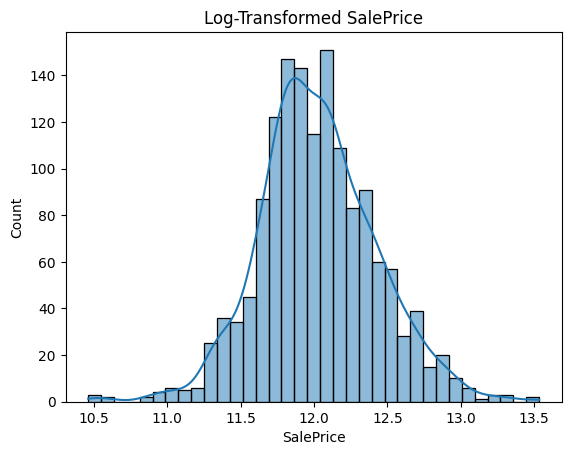

In [ ]:
# Apply log1p to target (helps if it's right-skewed)
train["SalePrice"] = np.log1p(train["SalePrice"])

# Confirm transformation
sns.histplot(train['SalePrice'], kde=True)
plt.title("Log-Transformed SalePrice")


In [ ]:
# Save target and drop it before encoding
y = train['SalePrice']
train.drop('SalePrice', axis=1, inplace=True)

# Combine datasets for consistent encoding
all_data = pd.concat([train, test], axis=0, sort=False)
print("Combined shape before encoding:", all_data.shape)


Combined shape before encoding: (2919, 80)


In [ ]:
# One-hot encode all categorical variables
all_data_encoded = pd.get_dummies(all_data)
print("Shape after One-Hot Encoding:", all_data_encoded.shape)


Shape after One-Hot Encoding: (2919, 288)


In [ ]:
# Split the encoded data back into train and test
X = all_data_encoded.iloc[:train.shape[0], :].copy()
X_test = all_data_encoded.iloc[train.shape[0]:, :].copy()

# Restore target variable
y = y.reset_index(drop=True)


In [ ]:
from sklearn.model_selection import train_test_split

# 70% train, 15% validation (so test_size = 0.15)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# Check dimensions
print("Train set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set (Kaggle):", X_test.shape)


Train set: (1241, 288)
Validation set: (219, 288)
Test set (Kaggle): (1459, 288)


In [ ]:
# Save the split datasets (optional but useful)
X_train.to_csv("X_train.csv", index=False)
X_val.to_csv("X_val.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_val.to_csv("y_val.csv", index=False)
